In [9]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('../data/stock_data_cleansed.csv')

In [11]:
df.head()

,Text,Sentiment
0,kicker watchlist xide tit soq pnk cpw bpz aj t...,1
1,user: aap movie. 55% return fea/geed indicator...,1
2,user id afraid short amzn - looking like near-...,1
3,mnta 12.00,1
4,oi 21.37,1


In [12]:
# Remove html tags in review column with regex
df = df.replace(to_replace ='<[^>]*>', value = '', regex = True)

In [13]:
df.head()

,Text,Sentiment
0,kicker watchlist xide tit soq pnk cpw bpz aj t...,1
1,user: aap movie. 55% return fea/geed indicator...,1
2,user id afraid short amzn - looking like near-...,1
3,mnta 12.00,1
4,oi 21.37,1


In [14]:
df.shape

(5791, 2)

In [15]:
X_train, X_test = df[:49900], df[49900:]
X_test

,Text,Sentiment


In [16]:
# Convert seentiment to numeric. In this case, 0 for positive and 1 for negative
#sentiment_label = df.sentiment.factorize()
#sentiment_label

In [17]:
# Assign a number to each word and replace with that number in the sentence

# Get the actual texts from the data frame
review = df.review.values
# Initialize the tokenizer with a 5000 word limit. This is the number of words we would like to encode
tokenizer = Tokenizer(num_words=5000)
# Call fit_on_texts to create associations of words and numbers as shown in the image below.
tokenizer.fit_on_texts(review)

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)
# As the model input requires to have equal length, the sequence is padded to have a length
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

AttributeError: 'DataFrame' object has no attribute 'review'

In [45]:
# Review and the corresponding numeric representation of it
print(review[0][:200])
print(padded_sequence[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was it
[  37  569   92    6 3800    7    1  359  355    4    1  661    8    6
  432 3182   13   11    6    1  357    5    1 2560 1062    8 2708 1420
   19  538   31 4659 2467    4    1 1207  116   28    1   24 2975    2
  390   33    6   20  297   19    1 4936  538    6  343    5  105 2451
    2   50   33  326    2   22  109  224  242    9   57  130    1  279
 1322    4    1  118    6  692    5    1  191   11    8  268  116   78
  275  588 3026  833  179 1319 4158   14 2520 1240  833 1442  833  886
 3182  148  953  182    1   85  397    9  122  209 3237   67   13   33
 1635    8   12 2242    9  412  130    9   12 1591   14    8   17   13
    9  286   50    9 1415    3 1279   14 3182    2  188    5    1  297
 2042    4 2149  569   20   38  569   17   25 2981   41   14    3  503
   19  641    2   

In [46]:
# Build the model

embedding_vector_length = 32

model = Sequential()

model.add(Embedding(vocab_size, embedding_vector_length, input_length=len(padded_sequence[0])))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           4048192   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 4,064,843
Trainable params: 4,064,843
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
history = model.fit(padded_sequence,sentiment_label[0],
                  validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
1250/1250 [==============================] - 196s 155ms/step - loss: 0.5219 - accuracy: 0.7177 - val_loss: 0.3220 - val_accuracy: 0.8639
Epoch 2/5
1250/1250 [==============================] - 192s 154ms/step - loss: 0.2973 - accuracy: 0.8790 - val_loss: 0.2941 - val_accuracy: 0.8803
Epoch 3/5
1250/1250 [==============================] - 191s 153ms/step - loss: 0.2754 - accuracy: 0.8900 - val_loss: 0.3133 - val_accuracy: 0.8791
Epoch 4/5
1250/1250 [==============================] - 193s 154ms/step - loss: 0.2483 - accuracy: 0.9009 - val_loss: 0.2974 - val_accuracy: 0.8824
Epoch 5/5
1250/1250 [==============================] - 188s 151ms/step - loss: 0.2386 - accuracy: 0.9041 - val_loss: 0.2801 - val_accuracy: 0.8860


In [48]:
def analyze_sentence(sentence):
    tw = tokenizer.texts_to_sequences([sentence])
    tw = pad_sequences(tw, maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print(model.predict(tw))
    return sentiment_label[1][prediction]

In [49]:
print(analyze_sentence("I saw this when it first came out and was shocked even then by the complete failure of the Hollywood hacks who made the film to either put Conan on the screen or even just make a decent movie. Phew. Recently, I tried to watch it again, twenty-odd years later - and I gagged. It's irredeemable. It's on a par with Plan 9. Only it's more boring."))

[[0.89907724]]
negative


In [50]:
model.save('./imdb_sentiment_analyzer')

INFO:tensorflow:Assets written to: ./imdb_sentiment_analyzer/assets


In [51]:
def analyze_sentence2(sentence:str, sentiment_score:int, serie):
    if sentiment_score == -1:
        sentiment_score = 0
    serie[0].append(sentiment_score)
    
    tw = tokenizer.texts_to_sequences([sentence])
    tw = pad_sequences(tw, maxlen=200)
    pred = model.predict(tw)
    prediction = int(pred.round().item())
    serie[1].append(pred[0])
    return sentiment_label[1][prediction]

series = [[],[]]
for text, sentiment in X_test.values[:100]:
    analyze_sentence2(text, sentiment, series)


Text(0.5, 1.0, 'Test Dataset')

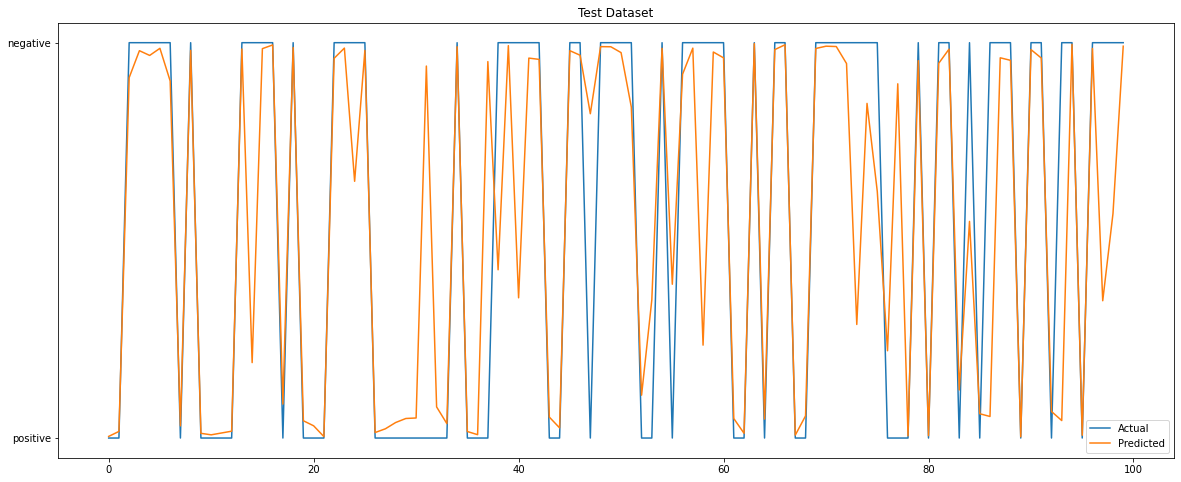

In [52]:
plt.figure(figsize=(20,8))

#Xt = model.predict(X_test)
#ax=[[series[0], series[1]]].plot()

plt.plot(series[0], label="Actual")
plt.plot(series[1], label="Predicted")
plt.legend()
plt.title("Test Dataset")